# Simulation Optimsiation using DES model of homeless response system

In [1]:
import datetime
print('Current version of this notebook updated ' + str(datetime.date.today()))

Current version of this notebook updated 2023-11-07


## Ranking & Selection

First we employ a Ranking & Selection algorithm based on the Kim & Nelson procedure. Details of this procedure can be found in section 9.3.2 (page 247) of 'Foundation and Methods of Stochastic Simulation' - Edition 2 (2021). The Python code for this procedure is found in the ranking_and_selection.py file in the GitHub repository. Below we import this module, and some others

In [2]:
# modules from this repository
import ranking_and_selection as rs
import simulation_model as sim
import queueing_model as qm

# external packages
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import json

### Testing using Inventory System

In order to test our KN procedure, we test it on a simulation model which has already been analysed using the KN algorithm in STOR-606 module - this is an $(s,S)$ inventory system where stock is replenished to a level of $S$ when it reaches $s$. 

In [3]:
solutions = [i for i in range(1600)]
k=np.array([i for i in range(1600)])

def simulate(solution):
    # one replication of simulating the cost of the inventory policy
    out=rs.InventorySystem(solution)[0]
    return out

In [4]:
random.seed(1)
opt_sols = []
for i in range(0):
    spc = rs.SolutionSpace(solutions)
    spc.optimise_rs(0.05, 50, 1, simulate, False, False)
    s,S = rs.get_sS_system(k[spc.active][0])
    opt_sols.append((s,S))

In [5]:
print('(s,S) for the optimal solution found at each iteration of the algorithm')
print(opt_sols)

(s,S) for the optimal solution found at each iteration of the algorithm
[]


The above illustrates that this KN algorithm can return different solutions when it is run at different times (i.e. with different starting seeds) - this is likely due to the difference between the true best and other good solutions being less than the 'delta' indiffference zone parameter used when running the algorithm above. 

In [6]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_simulation.json') as json_file:
    data_as_is_simulation = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical.json') as json_file:
    data_as_is_analytical = json.load(json_file)

### Developing a discrete solution space for the homeless response system

In [7]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [12,24]}
annual_budget = 36
accommodation_budgets = {'housing' : 120, 'shelter' : 120}
costs = {'housing': 1, 'shelter': 1}
build_rate_length_years = 6

# generate solution space
sols = rs.generate_solution_space(build_rate_options, 
                                  annual_budget, 
                                  accommodation_budgets, 
                                  costs, 
                                  build_rate_length_years)

sols = rs.keep_max_budget(sols, costs, annual_budget)

Below we initialise a solution space object with the solutions we have generated

In [8]:
spc = rs.SolutionSpace(sols)

### Analytic treatment of the solution space

In [9]:
# model analytically
outputs = []
for s in range(len(sols)):
    # create instance of queue
    q = qm.queue(data_as_is['arrival_rates'], 
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols[s], 
                 data_as_is['initial_demand'], 
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])

    q.model_dynamics(data_as_is['analysis_horizon'],
                     data_as_is_analytical['delta_t'])
    outputs.append(q.num_unsheltered_avg)
    print('done ' + str(s) + ' at time ' + str(datetime.datetime.now()))

done 0 at time 2023-11-07 18:46:07.133482
done 1 at time 2023-11-07 18:46:12.389463
done 2 at time 2023-11-07 18:46:17.618471
done 3 at time 2023-11-07 18:46:22.842074
done 4 at time 2023-11-07 18:46:28.211226
done 5 at time 2023-11-07 18:46:33.433697
done 6 at time 2023-11-07 18:46:38.592188
done 7 at time 2023-11-07 18:46:43.827334
done 8 at time 2023-11-07 18:46:48.935644
done 9 at time 2023-11-07 18:46:54.116429
done 10 at time 2023-11-07 18:46:59.293571
done 11 at time 2023-11-07 18:47:04.614901
done 12 at time 2023-11-07 18:47:09.848530
done 13 at time 2023-11-07 18:47:15.165161
done 14 at time 2023-11-07 18:47:20.450826
done 15 at time 2023-11-07 18:47:25.629659
done 16 at time 2023-11-07 18:47:30.930203
done 17 at time 2023-11-07 18:47:35.968698
done 18 at time 2023-11-07 18:47:41.236278
done 19 at time 2023-11-07 18:47:46.418790
done 20 at time 2023-11-07 18:47:51.641424
done 21 at time 2023-11-07 18:47:56.746655
done 22 at time 2023-11-07 18:48:02.033447
done 23 at time 2023-

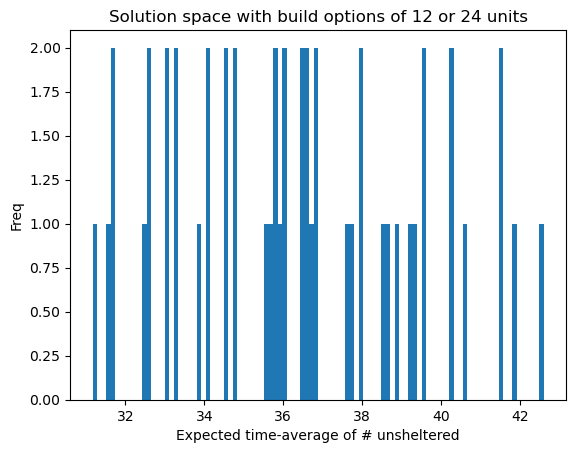

In [10]:
# Creating histogram 
fig, ax = plt.subplots(1, 1) 
ax.hist(outputs, 100) 
  
# Set title 
ax.set_title("Solution space with build options of 12 or 24 units") 
    
# adding labels 
ax.set_xlabel('Expected time-average of # unsheltered') 
ax.set_ylabel('Freq') 

plt.show()

In [11]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    my_dict[6] = " "
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+7] = element
    my_dict[13] = outputs[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'sh6', 'c']

In [17]:
# Looking at the improvements in the objective func given by a change in each dimension separately
low_val = 12
dims_all = ['h1','h2','h3','h4','h5','h6','sh1','sh2','sh3','sh4','sh5','sh6']
list_imprv = [] # data on improvements
for dim in dims_all:
    for i in df_analytic[df_analytic[dim]==low_val].index.tolist():
        value_base = df_analytic.iloc[i]['c']
        conditions = dim + '''!=''' + str(low_val)
        for dim_compare in [dims_all[j] for j in range(len(dims_all)) if dims_all[j]!=dim]:
            conditions = conditions + ''' & ''' + dim_compare + '==' + str(df_analytic.iloc[i][dim_compare])
        df_analytic_with_conditions = df_analytic.query(conditions).reset_index(drop=True)
        if len(df_analytic_with_conditions) > 0:
            value_improve = df_analytic_with_conditions['c'][0]
            improvement = value_base - value_improve
            improvement = {'dim': dim,
                           'imprv': improvement}
            list_imprv.append(improvement)
        
df_imprv = pd.DataFrame.from_dict(list_imprv)

In [18]:
# This will only work if we don't restrict the solution space to solutions where the budget is maxed out. 
#df_imprv_summary = df_imprv.groupby('dim').mean().reset_index()
#df_imprv_summary

Above we see that building housing early is the most favourable option given this setup - this makes intuitive sense given this set up because there is no difference in cost built in to favour one accommodation type over the other. Extra housing has the ability to begin service time for someone in shelter and also take someone out of the unsheltered queue and into shelter. Extra shelter only has the ability to do the latter. We might in future consider a service time in housing which is dependent on the time spent in shelter - because we might consider time in shelter as 'partial service'. 

Furthermore - it is also intuitive that building more housing or shelter units the earlier the better is most favourable - since this setup favours improvements to the unsheltered queue equally at all times, and early builds have an effect over a longer period of time. 

In [19]:
# Look at the difference between true best and true second-best 
df_analytic_sorted = df_analytic.sort_values('c').reset_index(drop=True)
indiff = df_analytic_sorted.iloc[1, df_analytic_sorted.columns.get_loc('c')] - df_analytic_sorted.iloc[0, df_analytic_sorted.columns.get_loc('c')]

### Sim Opt treatment of solution space

We next set a seed and then look for an optimal solution using the KN algorithm. A line of text is printed below whenever solutions are removed from the candidate list by the algorithm. We use the true difference between best and second-best solutions as the indifference zone parameter, and we use an alpha of 0.05 - leading to a lower bound of 95% confidence in what we find. 

In [ ]:
random.seed(1)
spc.optimise_rs(0.05, 
                100, 
                indiff, 
                sim.simulate_as_is, 
                True, 
                True, 
                data_as_is = data_as_is, 
                data_as_is_simulation = data_as_is_simulation)

starting routine at time  2023-11-07 18:57:05.510561


The details of the optimal solution are given below, followed by the following 20 solutions in decreasing order of the iteration number at which the KN algorithm removed them from the candidate list. 

In [22]:
# create dataframe of sim opt results
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+6] = element
    my_dict[12] = spc.eliminate[i]
    my_dict[13] = np.mean(spc.costs[i])
    my_dict[14] = np.var(spc.costs[i])
    my_list.append(my_dict)
df_sim = pd.DataFrame.from_dict(my_list)
df_sim.columns = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'sh6', 'iter_elim', 'sim_mean', 'sim_var']

We now reset the seed and repeatedly optimise with the same indifference-zone parameter, but now with alpha = 0.25 - we should see that at least 25% of the optimal solutions found are not the true best. 

In [ ]:
random.seed(5)
initial_reps = 5
spc = rs.SolutionSpace(sols)
spc.run_initial_reps(initial_reps,
                     sim.simulate_as_is,
                     data_as_is = data_as_is, 
                     data_as_is_simulation = data_as_is_simulation)
optim_sols = []
for i in range(500):
    spc.optimise_rs(0.5, 
                    initial_reps, 
                    indiff, 
                    sim.simulate_as_is, 
                    False, 
                    False, 
                    data_as_is = data_as_is, 
                    data_as_is_simulation = data_as_is_simulation)
    optim_sols.append(np.array(spc.solutions)[spc.active][0].solution)
    print('done ' + str(i) + str(np.array(spc.solutions)[spc.active][0].solution) + ' at time ' + str(datetime.datetime.now()))

### Analysis of analytic and Sim Opt outputs

Here we order the solutions based on their analytical objective function value - and compare the results to the results of the KN Sim Opt routine (first results from using alpha = 0.05 and running the algorithm once. 'iter_elim' is the iteration of the algorithm where the solution was eliminated, 0 when this solution was never eliminated - i.e. the optimal. 'c' is the analytical cost (i.e. expectation of the time average of the size of the unsheltered queue). 

In [13]:
df_concat = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True).merge(df_sim, on = ['h1', 'h2', 'h3', 'h4', 'h5', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5'])
df_concat.style.apply(lambda x: ["background: pink" if v == 24 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

,h1,h2,h3,h4,h5,,sh1,sh2,sh3,sh4,sh5,c,iter_elim,sim_mean,sim_var
0,24,24,24,12,12,,12,12,12,24,24,38.858750,0,38.248875,77.584929
1,24,24,24,12,12,,12,12,12,24,12,39.309859,1052,39.545348,80.418034
2,24,24,12,24,12,,12,12,24,12,24,39.761206,1008,39.895244,79.520932
3,24,24,12,12,24,,12,12,24,24,12,40.106998,868,39.978436,84.802684
4,24,24,12,12,12,,12,12,24,24,24,40.130147,1036,39.817412,82.189766
5,24,24,12,24,12,,12,12,24,12,12,40.239052,959,40.059616,86.693304
6,24,24,12,12,12,,12,12,24,24,12,40.630380,746,40.696451,90.041338
7,24,12,24,24,12,,12,24,12,12,24,41.290395,711,41.294285,86.979625
8,24,24,24,12,12,,12,12,12,12,24,41.627747,508,41.709430,87.291890
9,24,12,24,12,24,,12,24,12,24,12,41.649947,496,41.447380,81.385895


Above we see that the Sim Opt algorithm (KN) agrees with the analytic resuls that building housing early is the most favourable option given this setup. 

### A new solution space with shelter cheaper than housing

There are clearly some real-world benefits to building shelter rather than housing which we should to some extent incorporate into the model. Two benefits might include: 

* shelter is cheaper to build than housing
* shelter is quicker to build than housing. 

Firstly, we address the first bullet here and make shelter 0.5 times the price of housing. We achieve this by allowing double the number of shelter to be built, and changing the cost of the shelter, and keeping the annual budget the same. 

In [8]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [24, 48]}
annual_budget = 36
accommodation_budgets = {'housing' : 96, 'shelter' : 192}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 5

# geneate solution space
sols_cheap_shelter = rs.generate_solution_space(build_rate_options, annual_budget, accommodation_budgets, costs, build_rate_length_years)

In [12]:
# model analytically
outputs_cheap_shelter = []
for s in range(len(sols_cheap_shelter)):
    q = qm.queue(arrival_rates, 
                 service_mean['housing'], 
                 initial_capacity['housing'], 
                 initial_capacity['shelter'], 
                 [int(sols_cheap_shelter[s]['housing'][i]/num_annual_buildpoints) for i in range(len(sols_cheap_shelter[s]['housing']))], 
                 [int(sols_cheap_shelter[s]['shelter'][i]/num_annual_buildpoints) for i in range(len(sols_cheap_shelter[s]['shelter']))], 
                 initial_demand, 
                 max_in_system, 
                 num_annual_buildpoints, 
                 build_frequency_weeks)
    q.model_dynamics(4.75, d)
    outputs_cheap_shelter.append(q.num_unsheltered_avg)
    print('done ' + str(s) + ' at time ' + str(datetime.datetime.now()))

done 0 at time 2023-10-31 16:58:56.019355
done 1 at time 2023-10-31 16:59:04.948064
done 2 at time 2023-10-31 16:59:13.772141
done 3 at time 2023-10-31 16:59:22.780769
done 4 at time 2023-10-31 16:59:31.695853
done 5 at time 2023-10-31 16:59:40.624153
done 6 at time 2023-10-31 16:59:49.483943
done 7 at time 2023-10-31 16:59:58.221711
done 8 at time 2023-10-31 17:00:06.966173
done 9 at time 2023-10-31 17:00:15.695831
done 10 at time 2023-10-31 17:00:24.518158
done 11 at time 2023-10-31 17:00:33.214067
done 12 at time 2023-10-31 17:00:42.166016
done 13 at time 2023-10-31 17:00:51.209732
done 14 at time 2023-10-31 17:00:59.948642
done 15 at time 2023-10-31 17:01:08.794024
done 16 at time 2023-10-31 17:01:17.654958
done 17 at time 2023-10-31 17:01:26.580643
done 18 at time 2023-10-31 17:01:35.487503
done 19 at time 2023-10-31 17:01:44.596613
done 20 at time 2023-10-31 17:01:53.477990
done 21 at time 2023-10-31 17:02:02.396432
done 22 at time 2023-10-31 17:02:11.337354
done 23 at time 2023-

done 189 at time 2023-10-31 17:26:43.690532
done 190 at time 2023-10-31 17:26:52.422745
done 191 at time 2023-10-31 17:27:01.234109
done 192 at time 2023-10-31 17:27:10.026784
done 193 at time 2023-10-31 17:27:19.136836
done 194 at time 2023-10-31 17:27:27.995838
done 195 at time 2023-10-31 17:27:36.741591
done 196 at time 2023-10-31 17:27:45.584265
done 197 at time 2023-10-31 17:27:54.418239
done 198 at time 2023-10-31 17:28:03.069539
done 199 at time 2023-10-31 17:28:11.791727
done 200 at time 2023-10-31 17:28:20.353688
done 201 at time 2023-10-31 17:28:29.082283
done 202 at time 2023-10-31 17:28:37.706948
done 203 at time 2023-10-31 17:28:46.500084
done 204 at time 2023-10-31 17:28:55.276948
done 205 at time 2023-10-31 17:29:03.976781
done 206 at time 2023-10-31 17:29:12.756828
done 207 at time 2023-10-31 17:29:21.557573
done 208 at time 2023-10-31 17:29:30.358069
done 209 at time 2023-10-31 17:29:39.052961
done 210 at time 2023-10-31 17:29:47.827672
done 211 at time 2023-10-31 17:2

In [24]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols_cheap_shelter)):
    my_dict = {}
    for index, element in enumerate(sols_cheap_shelter[i]['housing']):
        my_dict[index] = element
    my_dict[5] = " "
    for index, element in enumerate(sols_cheap_shelter[i]['shelter']):
        my_dict[index+6] = element
    my_dict[11] = outputs_cheap_shelter[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', 'h5', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'c']

df_analytic = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True)
#df_analytic.style.apply(lambda x: ["background: pink" if v == 24 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)
df_analytic

,h1,h2,h3,h4,h5,,sh1,sh2,sh3,sh4,sh5,c
0,12,12,12,24,24,,48,48,48,24,24,12.832473
1,12,12,12,24,12,,48,48,48,24,24,12.832760
2,12,12,12,12,24,,48,48,48,24,24,12.855040
3,12,12,12,12,12,,48,48,48,24,24,12.859461
4,12,12,24,12,24,,48,48,24,48,24,13.061955
...,...,...,...,...,...,...,...,...,...,...,...,...
216,12,12,12,24,24,,24,24,24,24,24,44.262523
217,12,12,12,24,12,,24,24,24,24,24,44.779009
218,12,12,12,12,12,,24,24,24,24,48,47.060618
219,12,12,12,12,24,,24,24,24,24,24,47.578028


In [29]:
# Looking at the improvements in the objective func given by a change in each dimension separately

low_vals = [12, 12, 12, 12, 12, 24, 24, 24, 24, 24]
dims_all = ['h1','h2','h3','h4','h5','sh1','sh2','sh3','sh4','sh5']
list_imprv = [] # data on improvements
for dim in dims_all:
    for i in df_analytic[df_analytic[dim]==low_vals[dims_all.index(dim)]].index.tolist():
        value_base = df_analytic.iloc[i]['c']
        conditions = dim + '''!=''' + str(low_vals[dims_all.index(dim)])
        for dim_compare in [dims_all[j] for j in range(len(dims_all)) if dims_all[j]!=dim]:
            conditions = conditions + ''' & ''' + dim_compare + '==' + str(df_analytic.iloc[i][dim_compare])
        df_analytic_with_conditions = df_analytic.query(conditions).reset_index(drop=True)
        if len(df_analytic_with_conditions) > 0:
            value_improve = df_analytic_with_conditions['c'][0]
            improvement = value_base - value_improve
            improvement = {'dim': dim,
                           'imprv': improvement}
            list_imprv.append(improvement)
        
df_imprv = pd.DataFrame.from_dict(list_imprv)
df_imprv_summary = df_imprv.groupby('dim').mean().reset_index()
df_imprv_summary

,dim,imprv
0,h1,11.000772
1,h2,6.941819
2,h3,3.479564
3,h4,1.175077
4,h5,0.119653
5,sh1,15.793545
6,sh2,10.347681
7,sh3,5.310876
8,sh4,1.840018
9,sh5,0.206664


### A new solution space with shelter cheaper than housing and allowing zero shelter or zero housing to be built. 

In [46]:
# solution space constraints
build_rate_options = {'housing' : [0, 9, 18], 'shelter' : [0, 18, 36]}
annual_budget = 18
accommodation_budgets = {'housing' : 54, 'shelter' : 108}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 5

# geneate solution space
sols_cheap_shelter_inc_zero = rs.generate_solution_space(build_rate_options, annual_budget, accommodation_budgets, costs, build_rate_length_years)
sols_cheap_shelter_inc_zero = keep_max_budget(sols_cheap_shelter_inc_zero, costs, annual_budget)

In [47]:
# model analytically
outputs_cheap_shelter_inc_zero = []
for s in range(len(sols_cheap_shelter_inc_zero)):
    q = qm.queue(arrival_rates, 
                 service_mean['housing'], 
                 initial_capacity['housing'], 
                 initial_capacity['shelter'], 
                 [int(sols_cheap_shelter_inc_zero[s]['housing'][i]/num_annual_buildpoints) for i in range(len(sols_cheap_shelter_inc_zero[s]['housing']))], 
                 [int(sols_cheap_shelter_inc_zero[s]['shelter'][i]/num_annual_buildpoints) for i in range(len(sols_cheap_shelter_inc_zero[s]['shelter']))], 
                 initial_demand, 
                 max_in_system, 
                 num_annual_buildpoints, 
                 build_frequency_weeks)
    q.model_dynamics(4.75, d)
    outputs_cheap_shelter_inc_zero.append(q.num_unsheltered_avg)
    print('done ' + str(s) + ' at time ' + str(datetime.datetime.now()))

done 0 at time 2023-11-01 09:21:48.232591
done 1 at time 2023-11-01 09:21:57.335437
done 2 at time 2023-11-01 09:22:06.530769
done 3 at time 2023-11-01 09:22:15.648301
done 4 at time 2023-11-01 09:22:24.644192
done 5 at time 2023-11-01 09:22:33.556839
done 6 at time 2023-11-01 09:22:42.675652
done 7 at time 2023-11-01 09:22:51.609997
done 8 at time 2023-11-01 09:23:00.707919
done 9 at time 2023-11-01 09:23:09.663817
done 10 at time 2023-11-01 09:23:18.676541
done 11 at time 2023-11-01 09:23:27.875989
done 12 at time 2023-11-01 09:23:36.968418
done 13 at time 2023-11-01 09:23:45.980021
done 14 at time 2023-11-01 09:23:55.414123
done 15 at time 2023-11-01 09:24:04.315692
done 16 at time 2023-11-01 09:24:13.430369
done 17 at time 2023-11-01 09:24:22.458750
done 18 at time 2023-11-01 09:24:31.459933
done 19 at time 2023-11-01 09:24:40.459831
done 20 at time 2023-11-01 09:24:49.335583
done 21 at time 2023-11-01 09:24:58.273175
done 22 at time 2023-11-01 09:25:07.263300
done 23 at time 2023-

In [48]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols_cheap_shelter_inc_zero)):
    my_dict = {}
    for index, element in enumerate(sols_cheap_shelter_inc_zero[i]['housing']):
        my_dict[index] = element
    my_dict[5] = " "
    for index, element in enumerate(sols_cheap_shelter_inc_zero[i]['shelter']):
        my_dict[index+6] = element
    my_dict[11] = outputs_cheap_shelter_inc_zero[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', 'h5', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'c']

df_analytic = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True)
#df_analytic.style.apply(lambda x: ["background: pink" if v == 24 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)
df_analytic

,h1,h2,h3,h4,h5,,sh1,sh2,sh3,sh4,sh5,c
0,0,0,0,18,18,,36,36,36,0,0,63.114774
1,0,0,18,0,18,,36,36,0,36,0,65.532045
2,0,0,9,9,18,,36,36,18,18,0,66.969887
3,0,18,0,0,18,,36,0,36,36,0,67.043577
4,18,0,0,0,18,,0,36,36,36,0,67.649371
...,...,...,...,...,...,...,...,...,...,...,...,...
136,9,18,9,9,9,,18,0,18,18,18,82.829251
137,9,9,18,9,9,,18,18,0,18,18,83.129710
138,9,18,9,18,0,,18,0,18,0,36,83.355564
139,9,9,18,18,0,,18,18,0,0,36,83.656023


This indicates that given the new current set up - with cheaper shelter - shelter is always preferred over housing and even given the option of building a mix of shelter and housing, we would always opt for building no housing and all the shelter we can afford in this set up. 

### Exploring a range of different 'housing proportions'

In the previous example we looked at three different options each year: 

* 100\% housing
* 100\% shelter
* 1/3 housing, 2/3 shelter. 

The analytical results indicate (given current set up) that 100\% housing is preferred. We now want to look at a wider range of proportions for housing. 

We below develop a relatively small solution space, but covering a wider range of housing proportions. 

In [6]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [12,24]}
annual_budget = 36
accommodation_budgets = {'housing' : 96, 'shelter' : 96}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 5

# simulation options
number_reps = 1
initial_build_time = 63/365 # 9 weeks in years
initial_demand = 120
initial_capacity = {'housing' : 40, 'shelter' : 15}
arrival_rates = [35.0400, 42.0048, 46.2528, 46.2528, 41.6100] # in 1/year. One constant rate per year.
service_mean = {'housing' : (1/52)*(0+300+400)/3, 'shelter' : 0.0} # in years

# adjust arrival rates to include re-entries
reentry_rate = 0.17 # the proportion of those leaving accommodation which re-enter the system some time later
arrival_rate_reentries = (initial_capacity['housing']*reentry_rate)/service_mean['housing'] # assuming re-entries from the initial number of servers
arrival_rates = [i+arrival_rate_reentries for i in arrival_rates]#
time_btwn_changes_in_build_rate = (6*63)/365 # in years
time_btwn_building = 63/365 # in years. 63/365 years = 9 weeks.
reentry_rate = 0 # set this to zero now we have accounted for re-entries using an uplift to arrival rate

# increase demand so queue doesn't clear too quicly here
initial_demand = 180
arrival_rates = [i+20 for i in arrival_rates]

# additional params for analytical model
max_in_system = 1000
num_annual_buildpoints = 6
build_frequency_weeks = 9
d = 1 # days

# geneate solution space
house_builds = [0,1,2,3,4,5,6] # every two months
sols_range = []
for n in house_builds: 
    new_sol = {'housing':[0,0,0,0,0], 'shelter':[0,0,0,0,0]}
    for i in range(5):
        new_sol['housing'][i] = int(n*6)
        new_sol['shelter'][i] = int((annual_budget - (n*6))*(1/costs['shelter']))
    sols_range.append(new_sol)

In [7]:
sols_range

[{'housing': [0, 0, 0, 0, 0], 'shelter': [72, 72, 72, 72, 72]},
 {'housing': [6, 6, 6, 6, 6], 'shelter': [60, 60, 60, 60, 60]},
 {'housing': [12, 12, 12, 12, 12], 'shelter': [48, 48, 48, 48, 48]},
 {'housing': [18, 18, 18, 18, 18], 'shelter': [36, 36, 36, 36, 36]},
 {'housing': [24, 24, 24, 24, 24], 'shelter': [24, 24, 24, 24, 24]},
 {'housing': [30, 30, 30, 30, 30], 'shelter': [12, 12, 12, 12, 12]},
 {'housing': [36, 36, 36, 36, 36], 'shelter': [0, 0, 0, 0, 0]}]

In [56]:
# model analytically
outputs_range = []
for s in range(len(sols_range)):
    q = qm.queue(arrival_rates, 
                 service_mean['housing'], 
                 initial_capacity['housing'], 
                 initial_capacity['shelter'], 
                 [int(sols_range[s]['housing'][i]/num_annual_buildpoints) for i in range(len(sols_range[s]['housing']))], 
                 [int(sols_range[s]['shelter'][i]/num_annual_buildpoints) for i in range(len(sols_range[s]['shelter']))], 
                 initial_demand, 
                 max_in_system, 
                 num_annual_buildpoints, 
                 build_frequency_weeks)
    q.model_dynamics(4.75, d)
    outputs_range.append(q.num_unsheltered_avg)
    print('done ' + str(s) + ' at time ' + str(datetime.datetime.now()))

done 0 at time 2023-11-01 11:25:42.391468
done 1 at time 2023-11-01 11:25:51.190109
done 2 at time 2023-11-01 11:25:59.885396
done 3 at time 2023-11-01 11:26:08.442218
done 4 at time 2023-11-01 11:26:17.085449
done 5 at time 2023-11-01 11:26:25.685050
done 6 at time 2023-11-01 11:26:34.148016


In [8]:
x=[sols_range[i]['housing'][0]/(sols_range[i]['housing'][0] + sols_range[i]['shelter'][0]) for i in range(len(sols_range))]

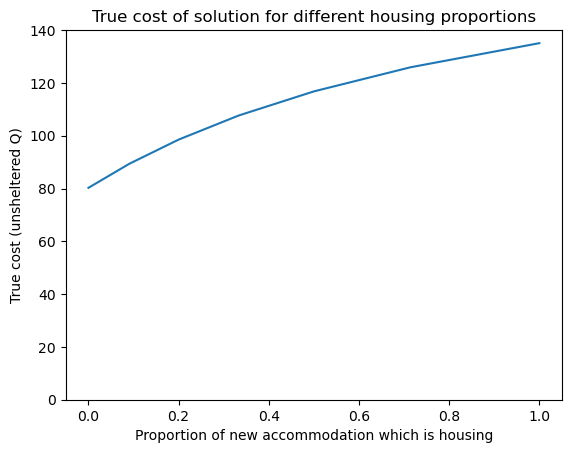

In [64]:
# setup
fig = plt.figure()
ax = plt.axes()

# plot
ax.plot(x, outputs_range)

# axes
plt.ylim([0, 140])

# Set title 
ax.set_title("True cost of solution for different housing proportions") 
    
# adding labels 
ax.set_xlabel('Proportion of new accommodation which is housing') 
ax.set_ylabel('True cost (unsheltered Q)') 

plt.show()

In [14]:
# model analytically - incorporating the cost of the sheltered queue
outputs_range_unsh = []
outputs_range_sh = []
for s in range(len(sols_range)):
    q = qm.queue(arrival_rates, 
                 service_mean['housing'], 
                 initial_capacity['housing'], 
                 initial_capacity['shelter'], 
                 [int(sols_range[s]['housing'][i]/num_annual_buildpoints) for i in range(len(sols_range[s]['housing']))], 
                 [int(sols_range[s]['shelter'][i]/num_annual_buildpoints) for i in range(len(sols_range[s]['shelter']))], 
                 initial_demand, 
                 max_in_system, 
                 num_annual_buildpoints, 
                 build_frequency_weeks)
    q.model_dynamics(4.75, d)
    outputs_range_unsh.append(q.num_unsheltered_avg)
    outputs_range_sh.append(q.num_sheltered_avg)
    print('done ' + str(s) + ' at time ' + str(datetime.datetime.now()))

done 0 at time 2023-11-01 14:20:12.044699
done 1 at time 2023-11-01 14:20:21.045343
done 2 at time 2023-11-01 14:20:29.890482
done 3 at time 2023-11-01 14:20:38.733456
done 4 at time 2023-11-01 14:20:47.210436
done 5 at time 2023-11-01 14:20:55.755761
done 6 at time 2023-11-01 14:21:04.244270


In [40]:
outputs_range_unsh

[80.2663502890362,
 89.39836702262885,
 98.53094471879088,
 107.66357102436918,
 116.79620072254875,
 125.92883061650507,
 135.06146051999306]

In [41]:
outputs_range_sh

[185.81850888971286,
 157.34673561446638,
 128.87440137663916,
 100.40201852939268,
 71.92963228955348,
 43.45724585393335,
 14.984859408780702]

In [48]:
def cost_function(sh,unsh):
    cost = 0.5*(sh**2)+(unsh**2)
    return cost

costs = []
for i in range(len(sols_range)):
    costs.append(cost_function(outputs_range_sh[i],outputs_range_unsh[i]))

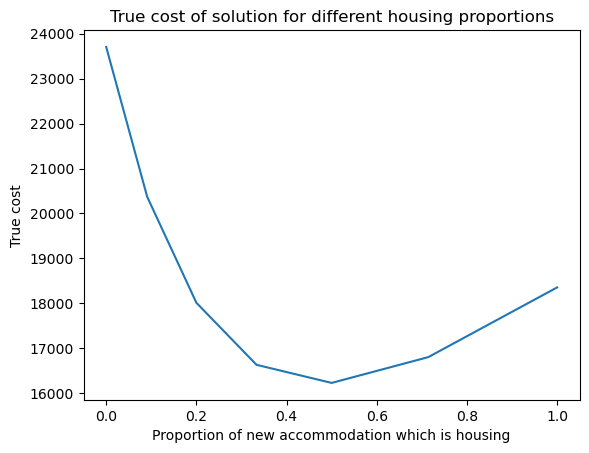

In [50]:
# setup
fig = plt.figure()
ax = plt.axes()

# plot
ax.plot(x, costs)

# axes
#plt.ylim([0, 140])

# Set title 
ax.set_title("True cost of solution for different housing proportions") 
    
# adding labels 
ax.set_xlabel('Proportion of new accommodation which is housing') 
ax.set_ylabel('True cost') 

plt.show()